In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
df = pd.read_csv('books.csv', error_bad_lines=False)

Skipping line 3350: expected 12 fields, saw 13
Skipping line 4704: expected 12 fields, saw 13
Skipping line 5879: expected 12 fields, saw 13
Skipping line 8981: expected 12 fields, saw 13



In [3]:
df.head(2)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.


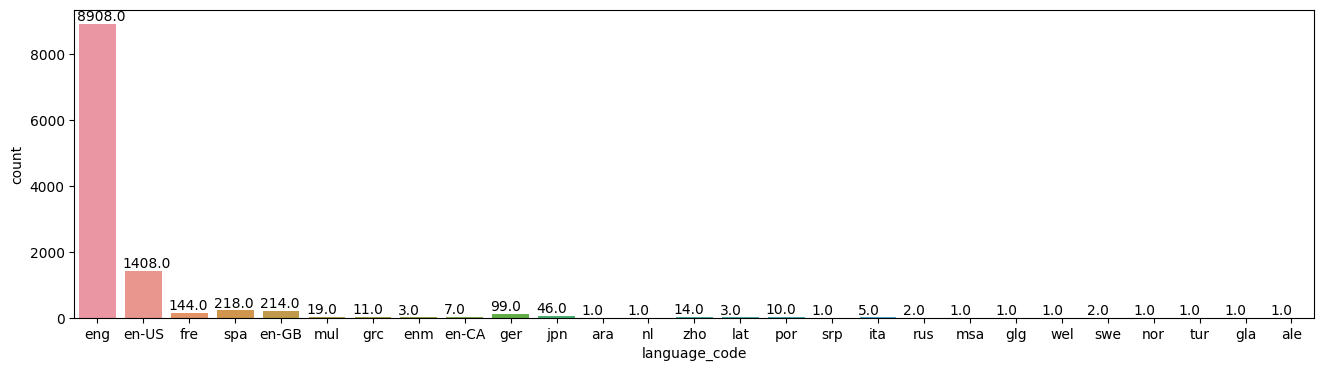

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,4))
ax = sns.countplot(x=df.language_code, data=df)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()-0.05, p.get_height()+100))

In [5]:
df = df.loc[df['language_code'].isin(['eng', 'en-US', 'en-GB', 'en-CA'])].reset_index()

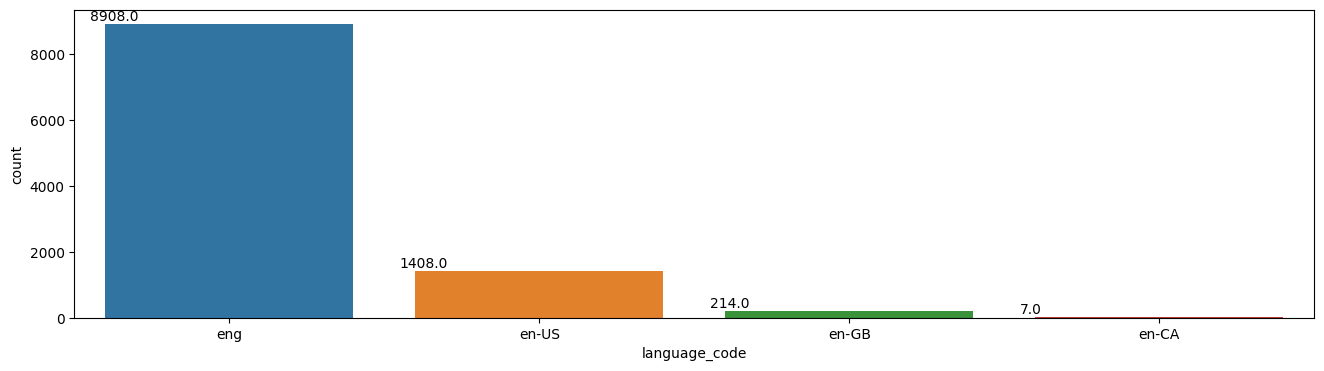

In [6]:
plt.figure(figsize=(16,4))
ax = sns.countplot(x=df.language_code, data=df)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()-0.05, p.get_height()+100))

**Popularity-based Recommender**

![alt_text](IMDB.png "IMDB Calculation")

In [7]:
def popularityRecommender(df):
    minimum_ratings_count = 0.75*df['ratings_count'].max()
    
    mean_rating = df['average_rating'].mean()
    
    df['weighted_rating'] = (((df['ratings_count']/(df['ratings_count']+minimum_ratings_count)) * df['average_rating']) + 
                             ((minimum_ratings_count/(df['ratings_count']+minimum_ratings_count))*mean_rating))
                             
    recommendations = df.sort_values(by = 'weighted_rating', ascending=False).head(5)              
    return(recommendations)

In [8]:
top5 = popularityRecommender(df)
top5.head(5)

,index,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,weighted_rating
3,3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.,4.185444
0,0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.,4.172746
1,1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.,4.146071
4169,4415,15881,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling/Mary GrandPré,4.42,0439064864,9780439064866,eng,341,2293963,34692,6/2/1999,Arthur A. Levine Books / Scholastic Inc.,4.126539
23,23,34,The Fellowship of the Ring (The Lord of the Ri...,J.R.R. Tolkien,4.36,0618346252,9780618346257,eng,398,2128944,13670,9/5/2003,Houghton Mifflin Harcourt,4.094953


In [9]:
top5Names = df['title'].head(5).values
print(top5Names)

['Harry Potter and the Half-Blood Prince (Harry Potter  #6)'
 'Harry Potter and the Order of the Phoenix (Harry Potter  #5)'
 'Harry Potter and the Chamber of Secrets (Harry Potter  #2)'
 'Harry Potter and the Prisoner of Azkaban (Harry Potter  #3)'
 'Harry Potter Boxed Set  Books 1-5 (Harry Potter  #1-5)']


**Content Based Recommender**

In [10]:
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

cbr = TfidfVectorizer(stop_words='english')

tfdf_matrix = cbr.fit_transform(df['title'])

distance_matrix = linear_kernel(tfdf_matrix)

indices = pd.Series(df.index, index=df['title']).drop_duplicates()

In [11]:
distance_matrix.size

111028369

In [12]:
def ContentBasedRecommender(title, indices, distance_matrix):
    id_=indices[title]
    distances = list(enumerate(distance_matrix[id_]))
    distances = sorted(distances, key=lambda x: x[1], reverse=True)
    distances = distances[1:6]
    recommendations = [distance[0] for distance in distances]
    return df['title'].iloc[recommendations]

In [13]:
ContentBasedRecommender('Poor People', indices, distance_matrix)

7292                  The Book of Other People
2872    The Working Poor: Invisible in America
3265                            All New People
9017                       A Man of the People
212              We Were Not Like Other People
Name: title, dtype: object

In [14]:
ContentBasedRecommender('Expelled from Eden: A William T. Vollmann Reader', indices, distance_matrix)

2315                 This Other Eden
7089                            Eden
2325    Who Was William Shakespeare?
5268                    West To Eden
1203                    East of Eden
Name: title, dtype: object

**Content Based Recommender based on Author**

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

cbr = TfidfVectorizer(stop_words='english')

tfdf_matrix = cbr.fit_transform(df['authors'])

distance_matrix = cosine_similarity(tfdf_matrix)

df = df.drop_duplicates(subset = 'authors')
indices = pd.Series(df.index, index=df['authors']).drop_duplicates(keep = 'first', inplace=False)

In [18]:
indices

authors
J.K. Rowling/Mary GrandPré                                    0
J.K. Rowling                                                  2
W. Frederick Zimmerman                                        5
Douglas Adams                                                 7
Douglas Adams/Stephen Fry                                    10
                                                          ...  
Sam R. Watkins                                            10527
Alexander Hunter                                          10528
David Wood/Roald Dahl                                     10529
Dave Crane/Eric Pascarello/Darren James                   10531
William T. Vollmann/Larry McCaffery/Michael Hemmingson    10533
Length: 6359, dtype: int64

In [19]:
distance_matrix

array([[1.        , 0.62374429, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.62374429, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [20]:
distance_matrix.shape

(6359, 6359)

In [21]:
def ContentBasedAuthorRecommender(author, indices, distance_matrix):
    id_ = indices[author]
    distances = list(enumerate(distance_matrix[id_]))
    distances = sorted(distances, key=lambda x: x[1], reverse=True)
    distances = distances[1:6]
    recommendations = [distance[0] for distance in distances]
    return df['authors'].iloc[recommendations]

In [22]:
ContentBasedAuthorRecommender('J.R.R. Tolkien', indices, distance_matrix)

6082                        J.V. Jones
7756    Richard Wright/Edward P. Jones
40       Edward P. Jones/Kevin R. Free
8226                  William    Jones
155                        Terry Jones
Name: authors, dtype: object